In [16]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import tqdm
import torch
import gpytorch
import pyro
from pyro.infer import Predictive

pyro.set_rng_seed(101)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append("../")
from models.kernels import CustomRBFKernel
from models.gp_regression import HealpixGPRegressionModel
from inference.constructor import ModelConstructor
from inference.trainer import PyroSVITrainer

In [3]:
# Load matplotlib settings
import warnings
import matplotlib.cbook
from plot_params import params
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

## Instantiate model and trainer

In [24]:
nside = 128

Loading the psf correction from: /Users/smsharma/PycharmProjects/fermi-gce-gp/notebooks/psf_dir/Fermi_PSF_2GeV.npy


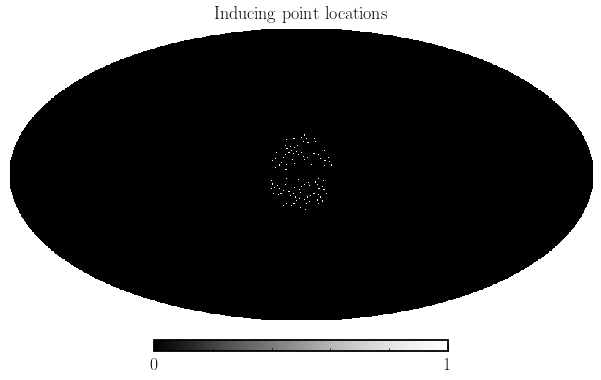

In [4]:
mc = ModelConstructor(nside=nside, 
                      r_outer=20, 
                      dif_sim='mO', dif_fit='p6', 
                      theta_poiss=[0.5, 0.1, 0.5, 0.9, 8.0, 4.0],
                      theta_ps=[0, 20.0, 1.8, -20.0, 20.0, 0.1],
                      guide_name="MVN", 
                      kernel="matern52", 
                      outputscale_prior=[0.5, 0.01], 
                      lengthscale_prior=[0.2, 0.001],
                      run_name="test_inducing_200_r_20.0_guide_MVN_ss_1500_os_[0.5, 0.01]_ls_[0.2, 0.001]_poiss_True", 
                      poiss_only=True,
                      num_inducing=200)

In [5]:
trainer = PyroSVITrainer(mc.model, mc.train_x, mc.train_y, mc.save_dir, optimizer_kwargs={"lr": 1e-3})

In [6]:
pyro.clear_param_store()

## Either run training or load save state

In [18]:
# # Run training
# trainer.train(num_iter=10000, batch_size=100, decay_every_steps=1000, save_every_steps=1000, num_particles=1, vectorize_particles=False)

In [7]:
# Load previous run
# `i` is training iteration
trainer.load_checkpoint(i=2001)

## Look at a few diagnostics

In [30]:
# All parameters and keys

for name in pyro.get_param_store().get_all_param_names():
    print(name)
#     print(name, pyro.param(name).data.numpy())

test_20_MVN_full_1_1_1_[0.5, 0.01].gp$$$variational_strategy.inducing_points
test_20_MVN_full_1_1_1_[0.5, 0.01].gp$$$variational_strategy._variational_distribution.variational_mean
test_20_MVN_full_1_1_1_[0.5, 0.01].gp$$$variational_strategy._variational_distribution.chol_variational_covar
test_20_MVN_full_1_1_1_[0.5, 0.01].gp$$$covar_module.raw_outputscale
test_20_MVN_full_1_1_1_[0.5, 0.01].gp$$$covar_module.base_kernel.raw_lengthscale
test_20_MVN_full_1_1_1_[0.5, 0.01].gp$$$mvn.loc_unconstrained
test_20_MVN_full_1_1_1_[0.5, 0.01].gp$$$mvn.scale_tril_unconstrained


In [31]:
mc.model.state_dict().keys()

odict_keys(['variational_strategy.inducing_points', 'variational_strategy.variational_params_initialized', 'variational_strategy.updated_strategy', 'variational_strategy._variational_distribution.variational_mean', 'variational_strategy._variational_distribution.chol_variational_covar', 'covar_module.raw_outputscale', 'covar_module.base_kernel.raw_lengthscale', 'covar_module.base_kernel.lengthscale_prior.loc', 'covar_module.base_kernel.lengthscale_prior.scale', 'covar_module.outputscale_prior.loc', 'covar_module.outputscale_prior.scale', 'mvn.loc_unconstrained', 'mvn.scale_tril_unconstrained'])

Text(0, 0.5, 'Loss')

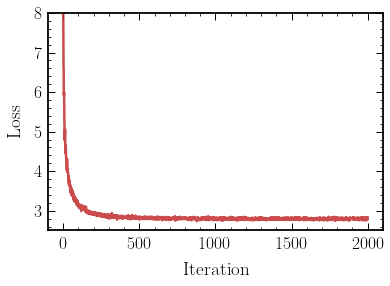

In [34]:
# Loss
plt.plot(trainer.loss)
plt.ylim(2.5, 8)
plt.xlabel("Iteration")
plt.ylabel("Loss")

In [13]:
# Outputscale
mc.model.state_dict()['variational_strategy._variational_distribution.chol_variational_covar']
mc.model.state_dict()['covar_module.raw_outputscale']
mc.model.covar_module.outputscale

tensor(0.4947, grad_fn=<SoftplusBackward>)

Text(0, 0.5, 'Pixel number')

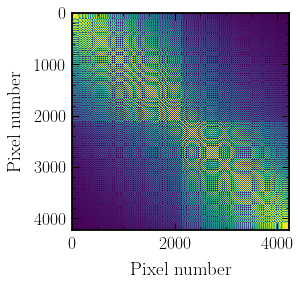

In [33]:
plt.imshow(mc.model.covar_module(mc.train_x).numpy())
plt.xlabel("Pixel number")
plt.ylabel("Pixel number")

## Draw from variational distributions to construct posterior

In [ ]:
# Ground truth mismodeling
mm = ((8. * mc.temp_mO_pibrem +  4. * mc.temp_mO_ics)/ (mc.temp_p6))[~mc.mask]

In [21]:
# Use `Predictive` to draw template params
mc.model.eval()
with torch.no_grad():
    predictive = Predictive(mc.model.model, guide=mc.model.guide, num_samples=100)
    pred = predictive(mc.train_x, mc.train_y, torch.arange(len(mc.train_x)))
pred.keys()

lower, median, upper = (mc.opt.x[-1]) * np.percentile((pred[mc.run_name + '.f(x)']).exp(), [5, 50, 95], axis=0)

`GPyTorch` bug in drawing GP parameters using `Predictive` (https://github.com/cornellius-gp/gpytorch/issues/1313) means evaluate directly to get GP draws:

In [19]:
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]
    return percentile_samples

In [23]:
test_x = mc.train_x

mc.model.eval()
with torch.no_grad():
    output = mc.model(test_x)

samples = output(torch.Size([100])).exp()
lower, median, upper = percentiles_from_samples(samples, percentiles=[0.025, 0.5, 0.975])

lower = mc.opt.x[-1] * lower.detach().numpy()
median = mc.opt.x[-1] * median.detach().numpy()
upper = mc.opt.x[-1] * upper.detach().numpy()

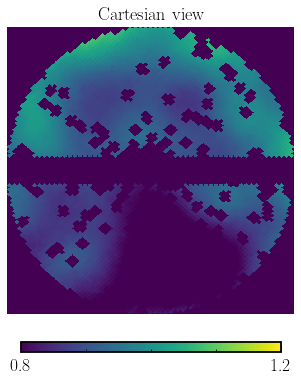

In [25]:
fwd = median / (mc.opt.x[-1])
fwd_map = np.zeros(hp.nside2npix(nside))
fwd_map[~mc.mask] = fwd
rpm = hp.cartview(fwd_map, min=0.8, max=1.2, lonra=[-20, 20], latra=[-20, 20], return_projected_map=True)
rpm.mask = (rpm.data == 0)

## Plot

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


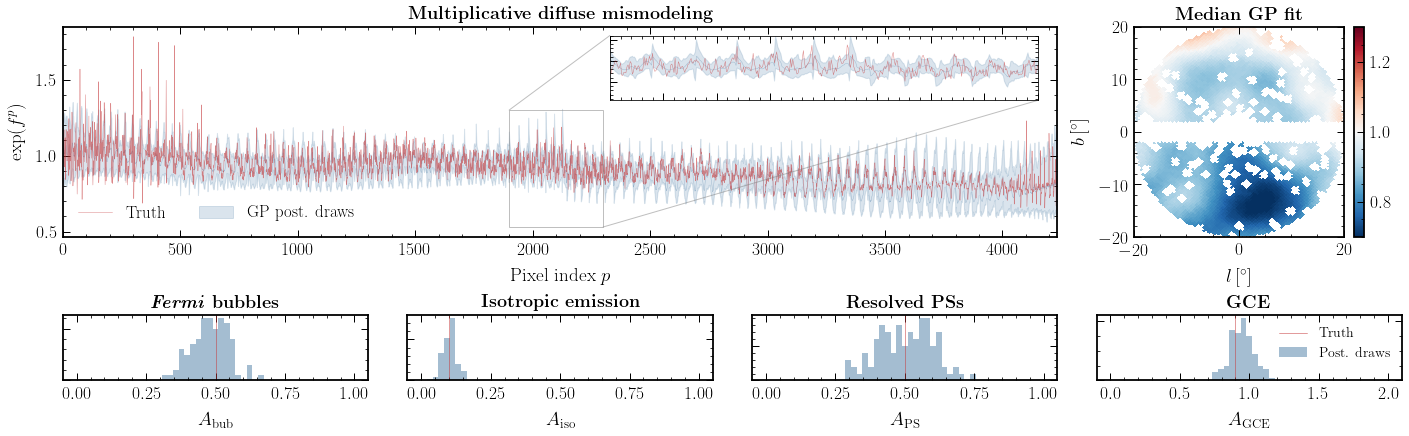

In [29]:
lw_truth = 0.5
fs_title = 18.

fig = plt.figure(constrained_layout=False, figsize=(24, 6.5))
ax = [None] * 6
gs = fig.add_gridspec(nrows=3, ncols=4, wspace=0.128, hspace=1.2)
ax[0] = fig.add_subplot(gs[:-1, : -1])
ax[1] = fig.add_subplot(gs[-1, 0])
ax[2] = fig.add_subplot(gs[-1, 1])
ax[3] = fig.add_subplot(gs[-1, 2])
ax[4] = fig.add_subplot(gs[-1, 3])
ax[5] = fig.add_subplot(gs[:-1, 3])

# Median GP and uncertainty

ax[0].fill_between(np.arange(len(lower)), lower / mc.opt.x[-1], upper / mc.opt.x[-1], alpha=0.2, color=cols_default[1], label="GP post. draws")
ax[0].plot(median / mc.opt.x[-1], color=cols_default[1], lw=lw_truth, alpha=0.4)
ax[0].plot(mm / mc.opt.x[-1], color=cols_default[0], label="Truth", lw=lw_truth, alpha=0.6)

ax[0].set_xlabel("Pixel index $p$")
ax[0].set_ylabel(r"$\exp(f^{p})$")
ax[0].set_title(r"\bf{Multiplicative diffuse mismodeling}", fontsize=fs_title)
ax[0].legend(loc='lower left', ncol=2)

# Inset
axins = ax[0].inset_axes([0.55, 0.65, 0.43, 0.31])
axins.fill_between(np.arange(len(lower)), lower / mc.opt.x[-1], upper / mc.opt.x[-1], alpha=0.2, color=cols_default[1], label="GP post. draws")
axins.plot(median / mc.opt.x[-1], color=cols_default[1], lw=lw_truth, alpha=0.4)
axins.plot(mm / mc.opt.x[-1], color=cols_default[0], label="Truth", lw=lw_truth, alpha=0.6)

x1, x2, y1, y2 = 1900, 2300, 0.53, 1.3
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels(r'')
axins.set_yticklabels(r'')

for axis in ['top','bottom','left','right']:
    axins.spines[axis].set_linewidth(0.8)

ax[0].indicate_inset_zoom(axins)

ax[0].set_xlim(0, len(mc.train_x))

# Template parameters

ax[1].hist((pred['bub'].detach().numpy()), label="Post. draws", color=cols_default[1], alpha=0.5, bins=np.linspace(0., 1., 50));
ax[1].axvline(.5, label="Truth", color=cols_default[0], lw=lw_truth)
ax[1].set_xlabel(r"$A_\mathrm{bub}$")
ax[1].set_title(r"\bf{\emph{Fermi} bubbles}", fontsize=fs_title)
ax[1].get_yaxis().set_ticklabels([])

ax[2].hist((pred['iso'].detach().numpy()), label="Post. draws", color=cols_default[1], alpha=0.5, bins=np.linspace(0., 1., 50));
ax[2].axvline(.1, label="Truth", color=cols_default[0], lw=lw_truth)
ax[2].set_xlabel(r"$A_\mathrm{iso}$")
ax[2].set_title(r"\bf{Isotropic emission}", fontsize=fs_title)
ax[2].get_yaxis().set_ticklabels([])

ax[3].hist((pred['psc'].detach().numpy()), label="Post. draws", color=cols_default[1], alpha=0.5, bins=np.linspace(0., 1., 50));
ax[3].axvline(.5, label="Truth", color=cols_default[0], lw=lw_truth)
ax[3].set_xlabel(r"$A_\mathrm{PS}$")
ax[3].set_title(r"\bf{Resolved PSs}", fontsize=fs_title)
ax[3].get_yaxis().set_ticklabels([])

ax[4].hist((pred['gce'].detach().numpy()), label="Post. draws", color=cols_default[1], alpha=0.5, bins=np.linspace(0., 2., 50));
ax[4].axvline(.9, label="Truth", color=cols_default[0], lw=lw_truth)
ax[4].set_xlabel(r"$A_\mathrm{GCE}$")
ax[4].set_title(r"\bf{GCE}", fontsize=fs_title)
ax[4].legend(fontsize=14)
ax[4].get_yaxis().set_ticklabels([])

# Median GP map
im = ax[5].imshow(rpm, origin='lower', vmin=0.7, vmax=1.3, cmap='RdBu_r', extent=[-20, 20, -20, 20])
ax[5].set_title(r"\bf{Median GP fit}", fontsize=fs_title)
ax[5].set_xlabel("$l\,[^\circ]$")
ax[5].set_ylabel("$b\,[^\circ]$")

from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="5%")
plt.colorbar(im, cax=cax)

plt.tight_layout()
# plt.savefig("../drafts/ml4ps/figures/inference.pdf", bbox_inches='tight')